## Create Model Geometry
#### use Gmsh to create geometry and mesh
#### created by D. Li
#### 6 Nov. 2023

In [1]:
# load model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
# from shapely.geometry import Point, LineString, Polygon
import os
import sys
import math

%matplotlib notebook

In [12]:
def find_fault_string(faultShp,strings):
    '''Find fault segments match 'string' and output sub table containing Fault_ID, Name, Dip_pref, SR_pref and Geometry'''
    gdf_xyz = gpd.read_file(faultShp,include_fields=["Fault_ID","Name", "Dip_pref","SR_pref","Geometry"])
    gdf_out = gpd.GeoDataFrame(columns=gdf_xyz.keys())
    # print(gdf_out)

    for string in strings:
        # print(string)
        # print(gdf_xyz[gdf_xyz['Name'].str.contains(string)])
        gdf_out = pd.concat([gdf_out,gdf_xyz[gdf_xyz['Name'].str.contains(string)]])
    
    return gdf_out
    

In [14]:
faultShp = os.path.join("/Users/shihao/Documents/NSHM/NSHM_SRM_model/NZ_CFM_v1_0_shapefile/","NZ_CFM_v1_0.shp")
PI = np.pi/180

# gdf_xyz = gpd.read_file(faultShp,include_fields=["Name", "Dip_pref","SR_pref","Geometry"])
# dip = gdf_xyz["Dip_pref"]
# print(dip[1])
# gdf_xyz = gpd.read_file(faultShp)
# print(gdf_xyz.keys())
fault1 = ['Humps','Hope',
          'Hundalee','Stone Jug','Point Kean','Leader','Conway-Charwell',
          'Papatea','Jodan Trust','Upper Kowai','Kekerengu','Needles',
         ]
fault1 = ['Kekerengu','Needles','Papatea','Jodan Trust']

faultTable = find_fault_string(faultShp,fault1)
print(faultTable)


    OBJECTID Fault_ID                Name  Name_stat     Lineage Fault_stat  \
240      242      578         Kekerengu 1  published  Unmodified       A-LS   
568      571      416      Kekerengu Bank  published  Unmodified       N-PS   
241      243      284  Wairarapa: Needles  published    Modified       A-LS   
635      638      573      Needles East 2   informal         New       A-LS   
636      639      570             Needles  published  Unmodified       A-LS   
360      362      581             Papatea  published         New       A-LS   

                          DomainName Domain_No Dip_pref  Dip_min  ...  \
240         Marlborough Fault System        14       60     50.0  ...   
568    Hikurangi accretionary margin         7       45     30.0  ...   
241  North Island Dextral Fault Belt         5       70     60.0  ...   
635         Marlborough Fault System        14       45     35.0  ...   
636         Marlborough Fault System        14       80     70.0  ...   
360     

In [46]:
df = faultTable[faultTable['Fault_ID']==578]
fxyz  = df["geometry"].to_numpy()
dip  = df['Dip_pref'].to_numpy()
strik  = df['SR_pref'].to_numpy()

print(fxyz[0])

LINESTRING (1689692.8095 5354993.5702, 1681515.6574 5351367.7279, 1675916.9961 5347379.3294, 1667518.0671 5339043.9048)


In [19]:
# generate GMsh model
import gmsh
# Helper function to return a node tag given two indices i and j:

def tag_fault(i,N):
    '''tag fault surface'''
    return N**2 +i 
        
def cal_mesh_lc(x0,y0,z0):
    ''' adaptive mesh based on distance to basin center'''
    xcc =1774453.12
    ycc =5451928.11
    zcc = -25e3
    lc = 5e3
    if z0 > -26000.0:
        if z0 > 0.0:
            lc =  500.0 # Densify the mesh for buildings
        else:
            if (np.sqrt((x0-xcc)**2 + (y0-ycc)**2 + (z0-zcc)**2)< 5e3):
                lc = 1000.0
            else:
                lc = 2000.0
        return lc
    else:
        return lc
        
def cal_mesh_size(entity_dim, entity_tag, x, y, z, lc):
    return cal_mesh_lc(x,y,z) 

def generate_mesh_fault(MeshFile,faultTable):
    '''create mesh file with fault segments, iteratively over fault segments, with any dip angle  '''

    # add faults s
    lc = 5000.0
    fwidth = 15000.0 
    f_ids = faultTable["Fault_ID"].unique()
    N = 100
    PI = np.pi/180

    gmsh.initialize()
    
    r = 5000.0
    resolution = 1000.0

    topo, xrange,yrange = load_topo_data(ncfile)
    
    xmin = xrange[0] # Unit (m)
    xmax = xrange[-1]
    ymin = yrange[0]
    ymax = yrange[-1]
    zmin = -50.0e3
    
    print(xmin,xmax,ymin,ymax)
    
    L, B, H = xmax-xmin, ymax-ymin, -zmin 
    x0, y0, z0 = xmin, ymin, zmin
    xc,yc,zc = (xmax+xmin)/2.0,(ymax+ymin)/2.0, -zmin/2.0
    v1 = gmsh.model.occ.addBox(x0,y0,z0, L, B, H)
    
    gmsh.model.occ.synchronize()  # must add synchronize before addPhysicalGroup
    surface_tags_box = gmsh.model.getEntities(dim=2)
    # print(surface_tags_box)

    for k,ids in enumerate(f_ids):
        # print(k,ids)
        df = faultTable[faultTable['Fault_ID']==ids]
        fxyz  = df["geometry"].get_coordinates()
        dip  = df['Dip_pref'].to_numpy()[0]
        strik  = df['SR_pref'].to_numpy()[0]
        
        for id in range(len(fxyz['x'])-1): 
            # print(id)
            point1 = gmsh.model.occ.add_point(np.asarray(fxyz['x'])[id], np.asarray(fxyz['y'])[id],100.0,lc)
            point2 = gmsh.model.occ.add_point(np.asarray(fxyz['x'])[id+1], np.asarray(fxyz['y'])[id+1],100.0,lc)
    
            line1 = gmsh.model.occ.add_line(point1, point2)
            face1 = gmsh.model.occ.extrude([(1,line1)],np.cos(dip*PI)*fwidth * np.sin((strik+90)*PI),np.cos(dip*PI)*fwidth *  np.cos((strik+90)*PI),-fwidth*np.sin(dip*PI))  
            gmsh.model.occ.synchronize()  # must add synchronize before addPhysicalGroup

           # Get the list of all surface tags
    
    surface_tags_all = gmsh.model.getEntities(dim=2)
    surface_tags = surface_tags_all[6::]
    # print(surface_tags)
    
    obstacles = []
    # Create a new physical group for surfaces
    for surface in surface_tags:
        obstacles.append(surface[1])
    
    # gmsh.model.addPhysicalGroup(2, obstacles,103) 
    print("fault surface:", obstacles)

    # gmsh.model.setPhysicalName(2, 103, "fault surface")
    gmsh.model.occ.synchronize()

    # for surface in surface_tags:
    #     v11 = gmsh.model.getEntities(3)
    #     print(v11,surface)
    #     gmsh.model.occ.fragment([(3,v11)],[surface],removeObject=True, removeTool=True )
    out, _ = gmsh.model.occ.fragment([(3, v1)], [(2, i) for i in obstacles])

    fault_surf = out[1::]
    print(fault_surf)
    
    faults = []
    # Create a new physical group for surfaces
    for surface in fault_surf:
        faults.append(surface[1])
        
    gmsh.model.occ.synchronize()
    # gmsh.model.addPhysicalGroup(2, faults,103) 
    # v2 = gmsh.model.getEntities(3)
    
    gmsh.model.addPhysicalGroup(3, [out[0][1]], 1)
    
    # Fault surface trace:
    gmsh.model.occ.synchronize()

    # Create a mesh size field
    # mesh_tag = gmsh.model.mesh.field.add("meshSize")
    # gmsh.model.mesh.field.setAsBackground(mesh_tag, 2,  obstacles)
    # gmsh.model.mesh.field.setNumber(mesh_tag, "MeshSize", resolution)

    distance = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(distance, "FacesList", obstacles)
    
    threshold = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(threshold, "IField", distance)
    gmsh.model.mesh.field.setNumber(threshold, "LcMin", resolution)
    gmsh.model.mesh.field.setNumber(threshold, "LcMax", 10*resolution)
    gmsh.model.mesh.field.setNumber(threshold, "DistMin", 0.5*r)
    gmsh.model.mesh.field.setNumber(threshold, "DistMax", r)
   
    minimum = gmsh.model.mesh.field.add("Min")
    gmsh.model.mesh.field.setNumbers(
        minimum, "FieldsList", [threshold])
    gmsh.model.mesh.field.setAsBackgroundMesh(minimum)

    gmsh.model.occ.synchronize()
    # Generate mesh:
    gmsh.model.mesh.generate(3)

    # label all elements on face
    # faces = gmsh.model.getBoundary([(3, out[0][1])],combined=True, oriented=False, recursive=False)
    faces = gmsh.model.getEntities(dim=2)
    
    print('all faces:',faces)

    
    absorb_end = []
    faults_end = []

    for surface in faces:
        com = gmsh.model.occ.getCenterOfMass(surface[0], surface[1])

        if np.allclose(com,[(xmax+xmin)/2.0, (ymax+ymin)/2.0, 0.0]):
            gmsh.model.addPhysicalGroup(surface[0], [surface[1]], 101)  # free-surfac boundary label
        elif np.sqrt((com[0]-xc)**2 + (com[1]-yc)**2) > 0.95 * (L+B)/4.0 : 
            absorb_end.append(surface[1])
        elif np.allclose(com,[(xmax+xmin)/2.0, (ymax+ymin)/2.0, zmin]):
            absorb_end.append(surface[1])
        else:
            faults_end.append(surface[1])

    print("dynamic BC:", faults_end)
    print("absorbing BC:", absorb_end)
            
    # add group 103 and 105 for test
    gmsh.model.addPhysicalGroup(2, absorb_end,105) 
    gmsh.model.addPhysicalGroup(2, faults_end,103) 

            
    # Write mesh data:
    gmsh.write(MeshFile + ".msh2")
     
    # Creates  graphical user interface
    # if 'close' not in sys.argv:
    #     gmsh.fltk.run()
     
    # It finalize the Gmsh API
    gmsh.finalize()


In [20]:
# gmsh.finalize()
    
rootfolder = '/Users/shihao/Documents/NSHM/'
ncfile = rootfolder + './Geometry/Kai_gebco_01mA.grd'
    
MeshFile = 'KaikouraFault4'
generate_mesh_fault(MeshFile,faultTable,ncfile)


(1746511.3065337986, 5426462.244420674)
1519825.7401575572 1810263.241695566 5127641.114570502 5458232.413812205


/Users/shihao/anaconda3/envs/Python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/Users/shihao/anaconda3/envs/Python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/shihao/anaconda3/envs/Python3.7/lib/python3.7/site-pack

AttributeError: 'GeoSeries' object has no attribute 'get_coordinates'

In [ ]:
# gmsh.finalize()

# load topographic data
# ncfile = '../Geometry/NZ_gebco_03sB.grd' # large domain
# rootfolder = '/Users/duoli/Documents/NSHM_SRM/'
# ncfile = rootfolder + './Geometry/NZ_gebco_03sB.grd'
# topo, xrange,yrange = load_topo_data(ncfile)|
# print(topo.shape,xrange.shape)

In [10]:
# generate a xdmf file for Paraview
import meshio

# Load the .msh file
def convert_mesh(MeshFile):
    
    mesh = meshio.read(
    MeshFile+ '.msh2',  # string, os.PathLike, or a buffer/open file
    file_format="gmsh",  # optional if filename is a path; inferred from extension
    )

    meshio.write(
    MeshFile+".vtk",  # str, os.PathLike, or buffer/ open file
    mesh,
    file_format="vtk",  # optional if first argument is a path; inferred from extension
    )
    

In [11]:
# filename = '/Users/duoli/Documents/NSHM_SRM/test_mesh'
convert_mesh(MeshFile)

In [17]:
from netCDF4 import Dataset
import pyproj


def load_topo_data(ncfile):
    nc = Dataset(ncfile,'r')
    lon= nc.variables['lon'][:]
    lat = nc.variables['lat'][:]
    topo = nc.variables['z'][:,:]
    lons,lats=np.meshgrid(lon,lat)

    samples = len(lon)
    
    min_latitude= lat.min()
    min_longitude= lon.min()
    
    max_latitude= lat.max()
    max_longitude= lon.max()
    
    mark_x = np.where( topo == -32768 )[0]
    mark_y = np.where( topo == -32768 )[1]
    # for x, y in zip(mark_x, mark_y) :
    #     slice = topo[max(0, x-1):x+1, max(0,y-1):y+1] # assuming a 5x5 square
    #     topo[x,y] = np.mean([i for i in slice.flatten() if i > 0])  # threshold is 0
    
    x_lon = np.linspace((min_longitude),(max_longitude),samples)
    y_lat = np.linspace((min_latitude),(max_latitude),samples)
    
    # UTM projection
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    # myproj = pyproj.Proj(proj='tmerc',lon_0=168, datum='WGS84')
    # myproj = pyproj.Proj(proj='utm',zone='59', datum='WGS84') # nzmg  
    myproj = pyproj.Proj(init='epsg:2193', datum='WGS84')
    
    xyz_map = pyproj.transform(lla, myproj, x_lon,y_lat,np.zeros(len(x_lon)), radians=False)
    x = xyz_map[0]
    y = xyz_map[1]
    # print(x,y)
    
    # Wellington city Epicenter coordinate
    lat_sou = -41.3
    lon_sou = 174.75 
    xyz_sou = pyproj.transform(lla, myproj, lon_sou,lat_sou, radians=False) # Epicenter in UTM domain
    print(xyz_sou)
    
    xmin = x[0] # Unit (m)
    xmax = x[-1]
    
    ymin = y[0]
    ymax = y[-1]

    return topo, x, y

In [ ]:
xmin = xrange[0] # Unit (m)
xmax = xrange[-1]

ymin = yrange[0]
ymax = yrange[-1]
# print(xmin,xmax,ymin,ymax)

zmax = -50.0e3
# print(x_lon.size, y_lat.size)


# Create the terrain mesh with N by N data points 
# (Make sure the spatial resolution matching topographic data):
N = 2160

# Helper function to return a node tag given two indices i and j:
def tag(i, j):
    return (N + 1) * i + j + 1

# The x, y, z coordinates of all the nodes:
coords = []

# The tags of the corresponding nodes:
nodes = []

# The connectivities of the triangle elements (3 node tags per triangle) on the
# terrain surface:
tris = []

# The connectivities of the line elements on the 4 boundaries (2 node tags
# for each line element):
lin = [[], [], [], []]

# The connectivities of the point elements on the 4 corners (1 node tag for each
# point element):
pnt = [tag(0, 0), tag(N, 0), tag(N, N), tag(0, N)]

# Adding topography point by point
x_grid = np.linspace(xmin,xmax,N+1)
y_grid = np.linspace(ymin,ymax,N+1)
print(x_grid.size,y_grid.size)
print(xmin,xmax,ymin,ymax)

In [6]:
# # Fault surface trace:

# line1 = gmsh.model.geo.add_line(point1, point2)
# line101 = gmsh.model.geo.add_line(point2, point102)
# line102 = gmsh.model.geo.add_line(point102, point101)
# line103 = gmsh.model.geo.add_line(point101, point1)

# line2 = gmsh.model.geo.add_line(point3, point4)
# line201 = gmsh.model.geo.add_line(point4, point104)
# line202 = gmsh.model.geo.add_line(point104, point103)
# line203 = gmsh.model.geo.add_line(point103, point3)

# line3 = gmsh.model.geo.add_line(point5, point6)
# line4 = gmsh.model.geo.add_line(point6, point7)
# line301 = gmsh.model.geo.add_line(point7, point107)
# line302 = gmsh.model.geo.add_line(point107, point106)
# line303 = gmsh.model.geo.add_line(point106, point105)
# line304 = gmsh.model.geo.add_line(point105, point5)


# line5 = gmsh.model.geo.add_line(point8, point9)
# line6 = gmsh.model.geo.add_line(point9, point10)
# line501 = gmsh.model.geo.add_line(point10, point110)
# line502 = gmsh.model.geo.add_line(point110, point109)
# line503 = gmsh.model.geo.add_line(point109, point108)
# line504 = gmsh.model.geo.add_line(point108, point8)


# line8 = gmsh.model.geo.add_line(point11, point12)
# line801 = gmsh.model.geo.add_line(point12, point112)
# line802 = gmsh.model.geo.add_line(point112, point111)
# line803 = gmsh.model.geo.add_line(point111, point11)


In [7]:
# face1 = gmsh.model.geo.add_curve_loop([line1, line101, line102, line103])
# face2 = gmsh.model.geo.add_curve_loop([line2, line201, line202, line203])

# face3 = gmsh.model.geo.add_curve_loop([line3, line4, line301, line302,line303,line304])
# face4 = gmsh.model.geo.add_curve_loop([line5, line6, line501, line502, line503,line504])

# face5 = gmsh.model.geo.add_curve_loop([line8, line801, line802, line803])

# gmsh.model.geo.add_plane_surface([face1])
# gmsh.model.geo.add_plane_surface([face2])
# # gmsh.model.geo.add_plane_surface([face3])
# gmsh.model.geo.add_plane_surface([face4])
# gmsh.model.geo.add_plane_surface([face5])


4

In [25]:
# # Create the relevant Gmsh data structures 
# # from Gmsh model.
# gmsh.model.geo.synchronize()
 
# # Generate mesh:
# gmsh.model.mesh.generate(2)
 
# # Write mesh data:
# gmsh.write("test_Wel.msh")
 
# # Creates  graphical user interface
# if 'close' not in sys.argv:
#     gmsh.fltk.run()
 
# # It finalize the Gmsh API
# gmsh.finalize()

In [7]:
grd_xyz = gpd.read_file(faultShp,include_fields=["Name", "Dip_pref","SR_pref","Geometry"])

In [8]:
# check which fault in alpine.
import pygmt 

grd_alpine = grd_xyz[grd_xyz['Name'].str.contains("Alpine")]
# grd_xyz = faultTable.get_coordinates()

print(faultTable)

fig1 = pygmt.Figure()

# fig1.plot(data=gdf,pen='0.50p,black')
fig1.plot(data=grd_alpine,pen='1.5p,maroon')

# # fig1.basemap(region=region_map, projection="M9c", frame="afg")
# for fault_id in gdf_well:
#     print(fault_id)
#     fig1.plot(data=fault_id, color='red')

fig1.show()

outname = "activate-fault-Alpine.png"
fig1.savefig(outname)

GMTVersionError: Using an incompatible GMT version 6.1.1. Must be equal or newer than 6.2.0.

/Users/duoli/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


[165.054 179.554 -50.237 -35.237]


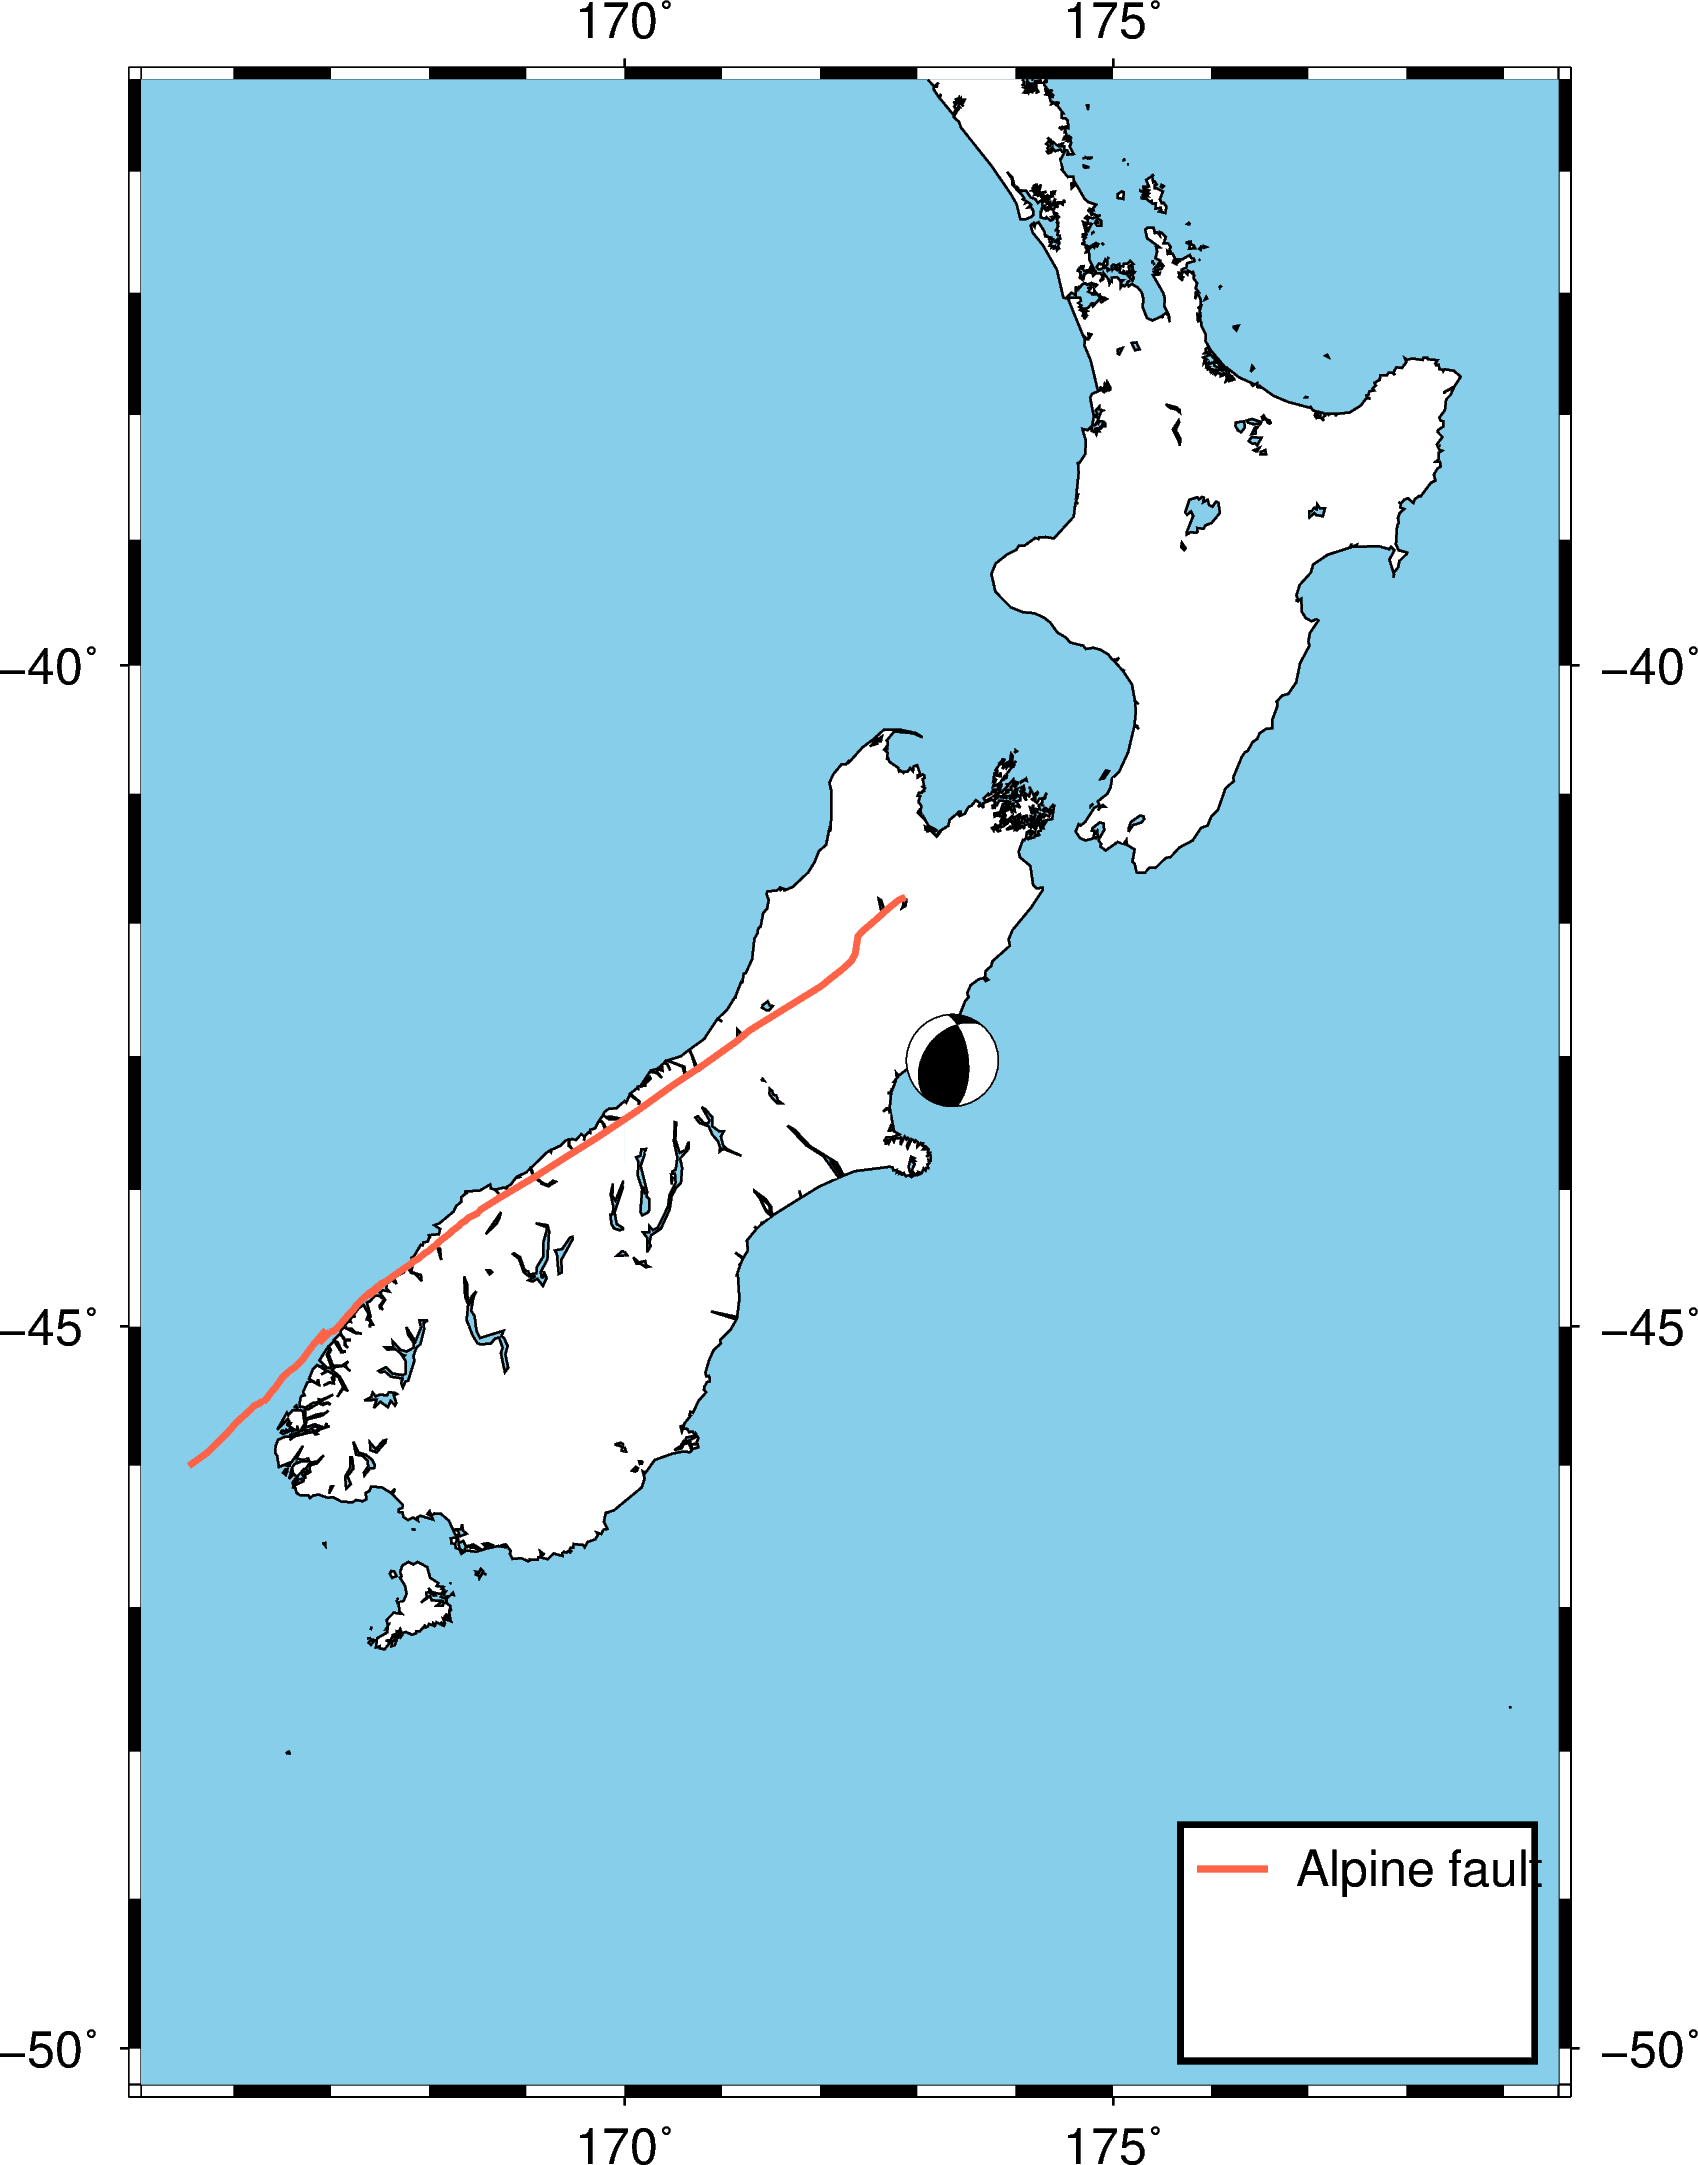

In [48]:
# print(grd_xyz)


main_caption = {"font": "12p,2,darkblue", "justify": "TC", "no_clip": True}
minor_caption = {"font": "10p,8", "justify": "TC", "no_clip": True}

focal_mechanism = dict(strike=219, dip=38, rake=128, magnitude=7.8)
locat = np.asarray([-42.737, 173.054])


grd_alpine["geometry"] = gpd.GeoSeries.to_crs(grd_alpine["geometry"],crs="EPSG:4326")

topo_data = '@earth_relief_01m'

locat_wel = np.asarray([-42.737, 173.054])
region_map = np.asarray([locat_wel[1]-8.0,locat_wel[1]+6.5,locat_wel[0]-7.5,locat_wel[0]+7.5])
print(region_map)

fig = pygmt.Figure()

fig.basemap(region=region_map, projection="M12c", frame="afg")
fig.coast(land="white", water="skyblue",shorelines='.50p,black')
# fig.grdimage(grid=topo_data, region=region_map,cmap='oleron')

# plot SHP file: active faults and community
fig.plot(data = grd_alpine,pen='1.5p,tomato',label='Alpine fault')
# fig.plot(data = gdf_well3,pen='1.5p,maroon',label='act. faults')

fig.meca(focal_mechanism, scale="0.5c", longitude=locat[1]+0.3, latitude=locat[0]-0.3, depth=15.1) # plot focal mechanism
# fig.plot(x=locat_wel[1], y=locat_wel[0], style="c0.2c",color='red') # plot focal mechanism

# # fig.plot(x=lon, y=lat, style="t0.5c", color='red',label='Stations') # plot stations
# # fig.text(x=lon, y=lat-0.2, text=sta, font=font) # plot station names

# fig.plot(data = faultShp)

fig.legend(position = 'jBR+jMR+o0.2c/1.2c+w3c/2c', box='+gwhite+p1.5p,black')
# fig.colorbar(position="JMR+o1.3c/0c+w7c/0.5c+v",frame=["a2000","x+lElevation", "y+lm"]) # position="x12.5c/6.6c+w6c+jTC+v"

fig.show()

outname = '/Users/duoli/Documents/NSHM_SRM/Geometry/' + 'geomap_Alpine.png'
fig.savefig(outname)

In [ ]:
def generate_mesh_fault(MeshFile,fxyz,strik,dip):
    '''create mesh file with fault segments '''
    
    gmsh.initialize()
    lc = 500.0
    width = 5000.0 
    
    point1 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[0], np.asarray(fxyz['y'])[0],0,lc)
    point2 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[1], np.asarray(fxyz['y'])[1],0,lc)
    
    point101 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[0]+np.cos(dip[0]*PI)*width * np.sin((strik[0]+90)*PI), 
                                        np.asarray(fxyz['y'])[0]+np.cos(dip[0]*PI)*width *  np.cos((strik[0]+90)*PI), 
                                        0 -width*np.sin(dip[0]*PI) ,
                                        lc)
    point102 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[1]+np.cos(dip[0]*PI)*width * np.sin((dip[0]+90)*PI), 
                                        np.asarray(fxyz['y'])[1]+np.cos(dip[0]*PI)*width * np.cos((dip[0]+90)*PI),
                                        0 -width*np.sin(dip[0]*PI),
                                        lc)
    
    point3 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[2], np.asarray(fxyz['y'])[2],0,lc)
    point4 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[3], np.asarray(fxyz['y'])[3],0,lc)
    
    point103 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[2]+np.cos(dip[1]*PI)*width * np.sin((strik[1]+90)*PI) , 
                                        np.asarray(fxyz['y'])[2]+np.cos(dip[1]*PI)*width *  np.cos((strik[1]+90)*PI), 
                                        0 -width*np.sin(dip[1]*PI) ,
                                        lc)
    point104 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[3]+np.cos(dip[1]*PI)*width * np.sin((dip[1]+90)*PI), 
                                        np.asarray(fxyz['y'])[3]+np.cos(dip[1]*PI)*width * np.cos((dip[1]+90)*PI),
                                        0 -width*np.sin(dip[1]*PI),
                                        lc)
    
    point5 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[4], np.asarray(fxyz['y'])[4],0,lc)
    point6 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[5], np.asarray(fxyz['y'])[5],0,lc)
    point7 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[6], np.asarray(fxyz['y'])[6],0,lc)
    
    
    point105 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[4]+np.cos(dip[2]*PI)*width * np.sin((strik[2]+90)*PI) , 
                                        np.asarray(fxyz['y'])[4]+np.cos(dip[2]*PI)*width *  np.cos((strik[2]+90)*PI), 
                                        0 -width*np.sin(dip[2]*PI) ,
                                        lc)
    point106 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[5]+np.cos(dip[2]*PI)*width * np.sin((dip[2]+90)*PI), 
                                        np.asarray(fxyz['y'])[5]+ np.cos(dip[2]*PI)*width * np.cos((dip[2]+90)*PI),
                                        0 -width*np.sin(dip[2]*PI),
                                        lc)
    point107 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[6]+np.cos(dip[2]*PI)*width * np.sin((dip[2]+90)*PI), 
                                        np.asarray(fxyz['y'])[6]+ np.cos(dip[2]*PI)*width * np.cos((dip[2]+90)*PI),
                                        0 -width*np.sin(dip[2]*PI),
                                        lc)
    
    
    point8 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[7], np.asarray(fxyz['y'])[7],0,lc)
    point9 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[8], np.asarray(fxyz['y'])[8],0,lc)
    point10 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[9], np.asarray(fxyz['y'])[9],0,lc)
    
    
    point108 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[7] + np.cos(dip[3]*PI)*width * np.sin((strik[3]+90)*PI) , 
                                        np.asarray(fxyz['y'])[7]+ np.cos(dip[3]*PI)*width *  np.cos((strik[3]+90)*PI), 
                                        0 -width*np.sin(dip[3]*PI) ,
                                        lc)
    point109 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[8] + np.cos(dip[3]*PI)*width * np.sin((dip[3]+90)*PI), 
                                        np.asarray(fxyz['y'])[8] +  np.cos(dip[3]*PI)*width * np.cos((dip[3]+90)*PI),
                                        0 -width*np.sin(dip[3]*PI),
                                        lc)
    point110 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[9] + np.cos(dip[3]*PI)*width * np.sin((dip[3]+90)*PI), 
                                        np.asarray(fxyz['y'])[9] +  np.cos(dip[3]*PI)*width * np.cos((dip[3]+90)*PI),
                                        0 -width*np.sin(dip[3]*PI),
                                        lc)
    
    
    
    point11 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[10], np.asarray(fxyz['y'])[10],0,lc)
    point12 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[11], np.asarray(fxyz['y'])[11],0,lc)
    
    point111 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[10] + np.cos(dip[4]*PI)*width * np.sin((strik[4]+90)*PI) , 
                                        np.asarray(fxyz['y'])[10]+ np.cos(dip[4]*PI)*width *  np.cos((strik[4]+90)*PI), 
                                        0 -width*np.sin(dip[4]*PI) ,
                                        lc)
    point112 = gmsh.model.geo.add_point(np.asarray(fxyz['x'])[11] + np.cos(dip[4]*PI)*width * np.sin((dip[4]+90)*PI), 
                                        np.asarray(fxyz['y'])[11] +  np.cos(dip[4]*PI)*width * np.cos((dip[4]+90)*PI),
                                        0 -width*np.sin(dip[4]*PI),
                                        lc)
    # Fault surface trace:

    # plane 1
    line1 = gmsh.model.geo.add_line(point1, point2)
    line101 = gmsh.model.geo.add_line(point2, point102)
    line102 = gmsh.model.geo.add_line(point102, point101)
    line103 = gmsh.model.geo.add_line(point101, point1)

    # plane 2
    line2 = gmsh.model.geo.add_line(point3, point4)
    line201 = gmsh.model.geo.add_line(point4, point104)
    line202 = gmsh.model.geo.add_line(point104, point103)
    line203 = gmsh.model.geo.add_line(point103, point3)

    # plane 3
    line3 = gmsh.model.geo.add_line(point5, point6)
    line31 = gmsh.model.geo.add_line(point6, point106)
    line303 = gmsh.model.geo.add_line(point106, point105)
    line304 = gmsh.model.geo.add_line(point105, point5)

    # plane 3-b
    
    line4 = gmsh.model.geo.add_line(point6, point7)
    line301 = gmsh.model.geo.add_line(point7, point107)
    line302 = gmsh.model.geo.add_line(point107, point106)
    line305 = gmsh.model.geo.add_line(point106, point6)
    
    
    # plane 4
    line5 = gmsh.model.geo.add_line(point8, point9)
    line51= gmsh.model.geo.add_line(point9,point109)
    line503 = gmsh.model.geo.add_line(point109, point108)
    line504 = gmsh.model.geo.add_line(point108, point8)

    # plane 4-b
    line6 = gmsh.model.geo.add_line(point9, point10)
    line501 = gmsh.model.geo.add_line(point10, point110)
    line502 = gmsh.model.geo.add_line(point110, point109)
    line505 = gmsh.model.geo.add_line(point109, point9)
    
    # plane 4-c
    line7 = gmsh.model.geo.add_line(point10, point11)
    line701 = gmsh.model.geo.add_line(point11, point111)
    line702 = gmsh.model.geo.add_line(point111, point110)
    line705 = gmsh.model.geo.add_line(point110, point10)

    
    
    # plane 5
    line8 = gmsh.model.geo.add_line(point11, point12)
    line801 = gmsh.model.geo.add_line(point12, point112)
    line802 = gmsh.model.geo.add_line(point112, point111)
    line803 = gmsh.model.geo.add_line(point111, point11)
    
        
    face1 = gmsh.model.geo.add_curve_loop([line1, line101, line102, line103])
    face2 = gmsh.model.geo.add_curve_loop([line2, line201, line202, line203])
    face3 = gmsh.model.geo.add_curve_loop([line3, line31,line303,line304])
    face32 = gmsh.model.geo.add_curve_loop([line4, line301, line302,line305])

    face4 = gmsh.model.geo.add_curve_loop([line5, line51, line503,line504])
    face42 = gmsh.model.geo.add_curve_loop([line6, line501,  line502, line505])
    face43 = gmsh.model.geo.add_curve_loop([line7, line701,  line702, line705])

    face5 = gmsh.model.geo.add_curve_loop([line8, line801, line802, line803])
    
    gmsh.model.geo.add_plane_surface([face1])
    gmsh.model.geo.add_plane_surface([face2])
    gmsh.model.geo.add_plane_surface([face3])
    gmsh.model.geo.add_plane_surface([face32])
    gmsh.model.geo.add_plane_surface([face42])
    gmsh.model.geo.add_plane_surface([face43])
    gmsh.model.geo.add_plane_surface([face4])
    gmsh.model.geo.add_plane_surface([face5])

    # Create the relevant Gmsh data structures 
    # from Gmsh model.
    gmsh.model.geo.synchronize()
     
    # Generate mesh:
    gmsh.model.mesh.generate(2)
     
    # Write mesh data:
    gmsh.write(MeshFile + ".msh2")
     
    # Creates  graphical user interface
    if 'close' not in sys.argv:
        gmsh.fltk.run()
     
    # It finalize the Gmsh API
    gmsh.finalize()


In [ ]:
# Create the terrain mesh with N by N data points 
    # (Make sure the spatial resolution matching topographic data):
    
    # The x, y, z coordinates of all the nodes:
    coords = []
    
    # The tags of the corresponding nodes:
    nodes = []
    
    # The connectivities of the triangle elements (3 node tags per triangle) on the
    # terrain surface:
    tris = []
    
    # The connectivities of the line elements on the 4 boundaries (2 node tags
    # for each line element):
    lin = [[], [], [], []]
    
    # The connectivities of the point elements on the 4 corners (1 node tag for each
    # point element):
    pnt = [tag(0, 0), tag(N, 0), tag(N, N), tag(0, N)]
    
    # Adding topography point by point
    x_grid = np.linspace(xmin,xmax,N+1)
    y_grid = np.linspace(ymin,ymax,N+1)

    # create topographic data:
    for i in range(N + 1):
        for j in range(N + 1):
            nodes.append(tag(i, j))
            ind_x = (np.abs(x_grid[i]-xrange)).argmin() # find the X index of nearest point in topo matrix
            ind_y = (np.abs(y_grid[j]-yrange)).argmin() # find the Y index of nearest point in topo matrix
            coords.extend([x_grid[i],y_grid[j],np.float64(topo[ind_y,ind_x])]) # Add the elevation 
            if i > 0 and j > 0:
                tris.extend([tag(i - 1, j - 1), tag(i, j - 1), tag(i - 1, j)]) 
                tris.extend([tag(i, j - 1), tag(i, j), tag(i - 1, j)])
            if (i == 0 or i == N) and j > 0:
                lin[3 if i == 0 else 1].extend([tag(i, j - 1), tag(i, j)])
            if (j == 0 or j == N) and i > 0:
                lin[0 if j == 0 else 2].extend([tag(i - 1, j), tag(i, j)])
    
    # Create 4 discrete points for the 4 corners of the terrain surface:
    for i in [0,1,2,3]:
        gmsh.model.addDiscreteEntity(0, i + 1)
    # print(tag(0,0),tag(N,0),tag(N,N),tag(0,N))
    points_all = gmsh.model.getEntities(dim=0)
    print(points_all)
    
    gmsh.model.setCoordinates(1, xmin, ymin, coords[3 * tag(0, 0) - 1])
    gmsh.model.setCoordinates(2, xmax, ymin, coords[3 * tag(N, 0)- 1])
    gmsh.model.setCoordinates(3, xmax, ymax, coords[3 * tag(N, N) - 1])
    gmsh.model.setCoordinates(4, xmin, ymax, coords[3 * tag(0, N) - 1])
    
    # Create 4 discrete bounding curves, with their boundary points:
    for i in [0,1,2,3]:
        gmsh.model.addDiscreteEntity(1, i + 1, [i + 1, i + 2 if i < 3 else 1])
    
    # Create one discrete surface, with its bounding curves:
    gmsh.model.addDiscreteEntity(2, 1, [1, 2, -3, -4])
    
    # Add all the nodes on the surface:
    gmsh.model.mesh.addNodes(2, 1, nodes, coords)
    gmsh.model.addPhysicalGroup(2, [1], 101) # Free-surface boundary label
    
    # Add point elements on the 4 points, line elements on the 4 curves, and triangle elements on the surface:
    for i in [0,1,2,3]:
        # Type 15 for point elements:
        gmsh.model.mesh.addElementsByType(i + 1, 15, [], [pnt[i]])
        # Type 1 for 2-node line elements:
        gmsh.model.mesh.addElementsByType(i + 1, 1, [], lin[i])
    # Type 2 for 3-node triangle elements:
    gmsh.model.mesh.addElementsByType(1, 2, [], tris)
    
    # Reclassify the nodes on the curves and the points 
    gmsh.model.mesh.reclassifyNodes()
    
    # Create a geometry for the discrete curves and surfaces, so that we can remesh them later on:
    gmsh.model.mesh.createGeometry()

    gmsh.model.occ.synchronize()
    
    print(points_all)
    # Create other entities to form one volume below the terrain surface:
    p1 = gmsh.model.geo.addPoint(xmin, ymin, zmax)
    p2 = gmsh.model.geo.addPoint(xmax, ymin, zmax)
    p3 = gmsh.model.geo.addPoint(xmax, ymax, zmax)
    p4 = gmsh.model.geo.addPoint(xmin, ymax, zmax)
    
    c1 = gmsh.model.occ.addLine(p1, p2)
    c2 = gmsh.model.occ.addLine(p2, p3)
    c3 = gmsh.model.occ.addLine(p3, p4)
    c4 = gmsh.model.occ.addLine(p4, p1)
    
    c10 = gmsh.model.occ.addLine(p1, points_all[0][1])
    c11 = gmsh.model.occ.addLine(p2, points_all[1][1])
    c12 = gmsh.model.occ.addLine(p3, points_all[2][1])
    c13 = gmsh.model.occ.addLine(p4, points_all[3][1])
    
    ll1 = gmsh.model.occ.addCurveLoop([c1, c2, c3, c4]) 
    s1 = gmsh.model.occ.addPlaneSurface([ll1]) # bot
    ll3 = gmsh.model.occ.addCurveLoop([c1, c11, -1, -c10]) # fro
    s3 = gmsh.model.occ.addPlaneSurface([ll3]) # fro
    ll4 = gmsh.model.occ.addCurveLoop([c2, c12, -2, -c11])
    s4 = gmsh.model.occ.addPlaneSurface([ll4]) # rig
    ll5 = gmsh.model.occ.addCurveLoop([c3, c13, 3, -c12])
    s5 = gmsh.model.occ.addPlaneSurface([ll5]) # bac 
    ll6 = gmsh.model.occ.addCurveLoop([c4, c10, 4, -c13])
    s6 = gmsh.model.occ.addPlaneSurface([ll6]) # lef